# Feature Engineering for Modeling 

## Steps to feature engineer: 
1. create candidate features 
    1. 4 week prior avgerage: points, yds, touches, touchdowns, fumbles, qbr 
        * impute missing data with 2018 stats
    2. opp win record, opp avg def pts allowed 
    3. isStarter, isHurt 
2. create incemental refresh schedule 
3. write final data set to Google Drive

## This notebook accomplishes step 1.A & writes the data 

### Loading utility functions

In [1]:
#importing various libraries 
import gspread 
#Service client credential from oauth2client
from oauth2client.service_account import ServiceAccountCredentials
# Print nicely
import pprint
#Create scope
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
#create some credential using that scope and content of startup_funding.json
creds = ServiceAccountCredentials.from_json_keyfile_name('../quickstart/g_sheet_creds.json',scope)
#create gspread authorize using that credential
client = gspread.authorize(creds)
my_email = 'matthewjchristy66@gmail.com'

In [2]:
#data manipulation 
import pandas as pd 
import numpy as np

In [3]:
def read_file(sheet_name):
    out = client.open(sheet_name).sheet1
    out = out.get_all_values()
    out = pd.DataFrame(out, columns = out.pop(0))
    return(out)

### Data Acq and Prep for Eng. 

In [4]:
#grabbing data for modeling 
passing = read_file(sheet_name = 'passing_processed_step1')

In [5]:
#creating a moving avg function 
def move_avg(df, smooth_col, group_vals, window):
    out = df.groupby(group_vals, as_index = False)[smooth_col].rolling(window = window).mean()
    out = out.reset_index(level = 0, drop = True)
    return(out)

In [6]:
#light cleaning 
pf = ['Comp', 'Att', 'Yds', 'TD', 'Int', 'Sck', 'FUM', 'Rate', 'passing_fantasy_pts']
passing[pf] = passing[pf].astype(float)

## Passing Feature Eng

In [7]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = passing.passing_fantasy_pts

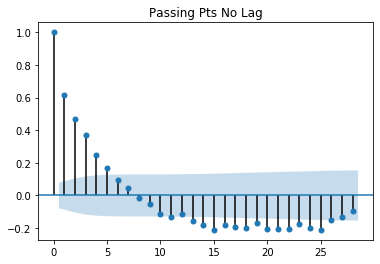

In [8]:
plot_acf(series, title = 'Passing Pts No Lag')
plt.show()

### Getting Lag Features

In [9]:
cols = ['Yds', 'TD', 'Rate', 'passing_fantasy_pts']
lag4 = ['lag4_' + ''.join(x) for x in cols]
lag2 = ['lag2_' + ''.join(x) for x in cols]

In [10]:
passing[lag4] = move_avg(df=passing, smooth_col=cols, group_vals='Name', window=4)
passing[lag2] = move_avg(df = passing, smooth_col=cols, group_vals='Name', window=2)

### Adding 2018 Recap Data for Imputation

In [12]:
pass_recap = read_file(sheet_name = '2018_passing_recap')

In [13]:
pass_recap[['Yds/G', 'TD', 'Int', 'Rate', '2018_ppg']] = pass_recap[['Yds/G', 'TD', 'Int', 'Rate', '2018_ppg']].astype(float)

In [14]:
pass_recap = pass_recap.rename(columns = {"Player":"Name", 'TD':'total_td', 'Int':'total_int', 'Rate':'avg_rate'})
pass_recap = pass_recap.drop('Team', axis = 1)

In [15]:
joined = pd.merge(passing, pass_recap, on = 'Name', how = 'inner')
joined = joined.drop_duplicates()

In [16]:
joined.loc[joined.Name == 'Lamar Jackson', :]

,Name,Week,Team,Opp,Score,Comp,Att,Yds,TD,Int,...,lag4_passing_fantasy_pts,lag2_Yds,lag2_TD,lag2_Rate,lag2_passing_fantasy_pts,Yds/G,total_td,total_int,avg_rate,2018_ppg
206,Lamar Jackson,1,BAL,@ MIA,W 59-10,17.0,20.0,324.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,75.1,6.0,3.0,84.5,4.3165
208,Lamar Jackson,2,BAL,vs ARI,W 23-17,24.0,37.0,272.0,2.0,0.0,...,NaN,298.0,3.5,131.55,25.92,75.1,6.0,3.0,84.5,4.3165
210,Lamar Jackson,3,BAL,@ KC,L 28-33,22.0,43.0,267.0,0.0,0.0,...,NaN,269.5,1.0,87.70,14.78,75.1,6.0,3.0,84.5,4.3165
212,Lamar Jackson,4,BAL,vs CLE,L 25-40,24.0,34.0,247.0,3.0,2.0,...,21.10,257.0,1.5,83.35,16.28,75.1,6.0,3.0,84.5,4.3165
214,Lamar Jackson,5,BAL,@ PIT,W 26-23,19.0,28.0,161.0,1.0,3.0,...,15.47,204.0,2.0,75.50,16.16,75.1,6.0,3.0,84.5,4.3165
216,Lamar Jackson,6,BAL,vs CIN,W 23-17,21.0,33.0,236.0,0.0,0.0,...,13.11,198.5,0.5,69.90,9.94,75.1,6.0,3.0,84.5,4.3165
218,Lamar Jackson,7,BAL,@ SEA,W 30-16,9.0,20.0,143.0,0.0,0.0,...,11.87,189.5,0.0,77.15,7.58,75.1,6.0,3.0,84.5,4.3165
220,Lamar Jackson,9,BAL,vs NE,W 37-20,17.0,23.0,163.0,1.0,0.0,...,9.03,153.0,0.5,88.55,8.12,75.1,6.0,3.0,84.5,4.3165
222,Lamar Jackson,10,BAL,@ CIN,W 49-13,15.0,17.0,223.0,3.0,0.0,...,11.65,193.0,2.0,133.00,15.72,75.1,6.0,3.0,84.5,4.3165
224,Lamar Jackson,11,BAL,vs HOU,W 41-7,17.0,24.0,222.0,4.0,0.0,...,15.51,222.5,3.5,148.75,22.90,75.1,6.0,3.0,84.5,4.3165


### Using `fillna()` method to coalesce the target columns

In [17]:
fill_vars = lag2 + lag4
fill_vars

['lag2_Yds',
 'lag2_TD',
 'lag2_Rate',
 'lag2_passing_fantasy_pts',
 'lag4_Yds',
 'lag4_TD',
 'lag4_Rate',
 'lag4_passing_fantasy_pts']

In [18]:
joined.lag2_Yds = joined['lag2_Yds'].fillna(joined['Yds/G'])
joined.lag2_TD  = joined['lag2_TD'].fillna(joined['total_td']/16)
joined.lag2_Rate = joined['lag2_Rate'].fillna(joined['avg_rate'])
joined.lag2_passing_fantasy_pts = joined['lag2_passing_fantasy_pts'].fillna(joined['2018_ppg'])

In [19]:
joined.head()

,Name,Week,Team,Opp,Score,Comp,Att,Yds,TD,Int,...,lag4_passing_fantasy_pts,lag2_Yds,lag2_TD,lag2_Rate,lag2_passing_fantasy_pts,Yds/G,total_td,total_int,avg_rate,2018_ppg
0,Andy Dalton,1,CIN,@ SEA,L 20-21,35.0,51.0,418.0,2.0,0.0,...,NaN,233.3,1.3125,89.60,13.8945,233.3,21.0,11.0,89.6,13.8945
2,Andy Dalton,2,CIN,vs SF,L 17-41,26.0,42.0,311.0,2.0,1.0,...,NaN,364.5,2.0000,98.50,22.5800,233.3,21.0,11.0,89.6,13.8945
4,Andy Dalton,3,CIN,@ BUF,L 17-21,20.0,36.0,250.0,1.0,2.0,...,NaN,280.5,1.5000,76.95,17.2200,233.3,21.0,11.0,89.6,13.8945
6,Andy Dalton,4,CIN,@ PIT,L 3-27,21.0,37.0,171.0,0.0,1.0,...,16.50,210.5,0.5000,60.40,10.4200,233.3,21.0,11.0,89.6,13.8945
8,Andy Dalton,5,CIN,vs ARI,L 23-26,27.0,38.0,262.0,2.0,0.0,...,14.94,216.5,1.0000,82.50,12.6600,233.3,21.0,11.0,89.6,13.8945


In [20]:
joined.lag4_Yds = joined['lag4_Yds'].fillna(joined['Yds/G'])
joined.lag4_TD  = joined['lag4_TD'].fillna(joined['total_td']/16)
joined.lag4_Rate = joined['lag4_Rate'].fillna(joined['avg_rate'])
joined.lag4_passing_fantasy_pts = joined['lag2_passing_fantasy_pts'].fillna('2018_ppg')

In [21]:
joined.loc[joined.Name == 'Lamar Jackson']

,Name,Week,Team,Opp,Score,Comp,Att,Yds,TD,Int,...,lag4_passing_fantasy_pts,lag2_Yds,lag2_TD,lag2_Rate,lag2_passing_fantasy_pts,Yds/G,total_td,total_int,avg_rate,2018_ppg
206,Lamar Jackson,1,BAL,@ MIA,W 59-10,17.0,20.0,324.0,5.0,0.0,...,4.3165,75.1,0.375,84.50,4.3165,75.1,6.0,3.0,84.5,4.3165
208,Lamar Jackson,2,BAL,vs ARI,W 23-17,24.0,37.0,272.0,2.0,0.0,...,25.9200,298.0,3.500,131.55,25.9200,75.1,6.0,3.0,84.5,4.3165
210,Lamar Jackson,3,BAL,@ KC,L 28-33,22.0,43.0,267.0,0.0,0.0,...,14.7800,269.5,1.000,87.70,14.7800,75.1,6.0,3.0,84.5,4.3165
212,Lamar Jackson,4,BAL,vs CLE,L 25-40,24.0,34.0,247.0,3.0,2.0,...,16.2800,257.0,1.500,83.35,16.2800,75.1,6.0,3.0,84.5,4.3165
214,Lamar Jackson,5,BAL,@ PIT,W 26-23,19.0,28.0,161.0,1.0,3.0,...,16.1600,204.0,2.000,75.50,16.1600,75.1,6.0,3.0,84.5,4.3165
216,Lamar Jackson,6,BAL,vs CIN,W 23-17,21.0,33.0,236.0,0.0,0.0,...,9.9400,198.5,0.500,69.90,9.9400,75.1,6.0,3.0,84.5,4.3165
218,Lamar Jackson,7,BAL,@ SEA,W 30-16,9.0,20.0,143.0,0.0,0.0,...,7.5800,189.5,0.000,77.15,7.5800,75.1,6.0,3.0,84.5,4.3165
220,Lamar Jackson,9,BAL,vs NE,W 37-20,17.0,23.0,163.0,1.0,0.0,...,8.1200,153.0,0.500,88.55,8.1200,75.1,6.0,3.0,84.5,4.3165
222,Lamar Jackson,10,BAL,@ CIN,W 49-13,15.0,17.0,223.0,3.0,0.0,...,15.7200,193.0,2.000,133.00,15.7200,75.1,6.0,3.0,84.5,4.3165
224,Lamar Jackson,11,BAL,vs HOU,W 41-7,17.0,24.0,222.0,4.0,0.0,...,22.9000,222.5,3.500,148.75,22.9000,75.1,6.0,3.0,84.5,4.3165


### Lagging the data to actually use for prediction 
- use `df.shift(periods = 1)` for the measured data 
- impute again to recover missing rows 
- user prior year data for week 1
- use week 1 + prior year data for week 2
    - generate column of prior week data 

In [22]:
joined[fill_vars] = joined.groupby('Name')[fill_vars].shift(periods = 1, axis = 0)

In [23]:
joined.lag2_Yds = joined['lag2_Yds'].fillna(joined['Yds/G'])
joined.lag2_TD  = joined['lag2_TD'].fillna(joined['total_td']/16)
joined.lag2_Rate = joined['lag2_Rate'].fillna(joined['avg_rate'])
joined.lag2_passing_fantasy_pts = joined['lag2_passing_fantasy_pts'].fillna(joined['2018_ppg'])

In [24]:
joined.lag4_Yds = joined['lag4_Yds'].fillna(joined['Yds/G'])
joined.lag4_TD  = joined['lag4_TD'].fillna(joined['total_td']/16)
joined.lag4_Rate = joined['lag4_Rate'].fillna(joined['avg_rate'])
joined.lag4_passing_fantasy_pts = joined['lag2_passing_fantasy_pts'].fillna('2018_ppg')

In [25]:
joined[joined.Name == 'Andy Dalton']

,Name,Week,Team,Opp,Score,Comp,Att,Yds,TD,Int,...,lag4_passing_fantasy_pts,lag2_Yds,lag2_TD,lag2_Rate,lag2_passing_fantasy_pts,Yds/G,total_td,total_int,avg_rate,2018_ppg
0,Andy Dalton,1,CIN,@ SEA,L 20-21,35.0,51.0,418.0,2.0,0.0,...,13.8945,233.3,1.3125,89.60,13.8945,233.3,21.0,11.0,89.6,13.8945
2,Andy Dalton,2,CIN,vs SF,L 17-41,26.0,42.0,311.0,2.0,1.0,...,13.8945,233.3,1.3125,89.60,13.8945,233.3,21.0,11.0,89.6,13.8945
4,Andy Dalton,3,CIN,@ BUF,L 17-21,20.0,36.0,250.0,1.0,2.0,...,22.5800,364.5,2.0000,98.50,22.5800,233.3,21.0,11.0,89.6,13.8945
6,Andy Dalton,4,CIN,@ PIT,L 3-27,21.0,37.0,171.0,0.0,1.0,...,17.2200,280.5,1.5000,76.95,17.2200,233.3,21.0,11.0,89.6,13.8945
8,Andy Dalton,5,CIN,vs ARI,L 23-26,27.0,38.0,262.0,2.0,0.0,...,10.4200,210.5,0.5000,60.40,10.4200,233.3,21.0,11.0,89.6,13.8945
10,Andy Dalton,6,CIN,@ BAL,L 17-23,21.0,39.0,235.0,0.0,1.0,...,12.6600,216.5,1.0000,82.50,12.6600,233.3,21.0,11.0,89.6,13.8945
12,Andy Dalton,7,CIN,vs JAX,L 17-27,22.0,43.0,276.0,1.0,3.0,...,13.9400,248.5,1.0000,84.50,13.9400,233.3,21.0,11.0,89.6,13.8945
14,Andy Dalton,8,CIN,@ LA,L 10-24,32.0,52.0,329.0,1.0,0.0,...,12.2200,255.5,0.5000,55.75,12.2200,233.3,21.0,11.0,89.6,13.8945
16,Andy Dalton,13,CIN,vs NYJ,W 22-6,22.0,37.0,243.0,1.0,0.0,...,16.1000,302.5,1.0000,68.10,16.1000,233.3,21.0,11.0,89.6,13.8945
18,Andy Dalton,14,CIN,@ CLE,L 19-27,22.0,38.0,262.0,0.0,1.0,...,15.4400,286.0,1.0000,87.05,15.4400,233.3,21.0,11.0,89.6,13.8945


In [33]:
joined.columns

Index(['Name', 'Week', 'Team', 'Opp', 'Score', 'Comp', 'Att', 'Yds', 'TD',
       'Int', 'Sck', 'FUM', 'Rate', '300yd_flag', 'passing_fantasy_pts',
       'lag4_Yds', 'lag4_TD', 'lag4_Rate', 'lag4_passing_fantasy_pts',
       'lag2_Yds', 'lag2_TD', 'lag2_Rate', 'lag2_passing_fantasy_pts', 'Yds/G',
       'total_td', 'total_int', 'avg_rate', '2018_ppg'],
      dtype='object')

In [26]:
#Getting the prior week stats lagged 
cols2 = ['Opp', 'Score', 'Yds', 'TD', 'Int', 'Rate', '300yd_flag', 'passing_fantasy_pts']
prior_week = ['last_week_' + ''.join(x) for x in cols2]
prior_week

['last_week_Opp',
 'last_week_Score',
 'last_week_Yds',
 'last_week_TD',
 'last_week_Int',
 'last_week_Rate',
 'last_week_300yd_flag',
 'last_week_passing_fantasy_pts']

In [27]:
joined[prior_week] = joined.groupby('Name')[cols2].shift(periods = 1, axis = 0)

In [28]:
joined['yds_ratio'] = joined.lag4_Yds/joined.lag2_Yds
joined['rate_ratio'] = joined.lag4_Rate/joined.lag2_Rate
joined['fantasy_pts_ratio'] = joined.lag4_passing_fantasy_pts/joined.lag2_passing_fantasy_pts

In [36]:
passing_almost_final = joined.drop(pass_recap.columns, axis = 1)

In [37]:
pd.set_option('display.max_columns', None)
passing_almost_final.head()

,Week,Team,Opp,Score,Comp,Att,Yds,TD,Int,Sck,FUM,Rate,300yd_flag,passing_fantasy_pts,lag4_Yds,lag4_TD,lag4_Rate,lag4_passing_fantasy_pts,lag2_Yds,lag2_TD,lag2_Rate,lag2_passing_fantasy_pts,last_week_Opp,last_week_Score,last_week_Yds,last_week_TD,last_week_Int,last_week_Rate,last_week_300yd_flag,last_week_passing_fantasy_pts,yds_ratio,rate_ratio,fantasy_pts_ratio
0,1,CIN,@ SEA,L 20-21,35.0,51.0,418.0,2.0,0.0,5.0,2.0,106.5,1,24.72,233.3,1.3125,89.60,13.8945,233.3,1.3125,89.60,13.8945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.0
2,2,CIN,vs SF,L 17-41,26.0,42.0,311.0,2.0,1.0,4.0,0.0,90.5,1,20.44,233.3,1.3125,89.60,13.8945,233.3,1.3125,89.60,13.8945,@ SEA,L 20-21,418.0,2.0,0.0,106.5,1,24.72,1.000000,1.000000,1.0
4,3,CIN,@ BUF,L 17-21,20.0,36.0,250.0,1.0,2.0,2.0,0.0,63.4,0,14.00,233.3,1.3125,89.60,22.5800,364.5,2.0000,98.50,22.5800,vs SF,L 17-41,311.0,2.0,1.0,90.5,1,20.44,0.640055,0.909645,1.0
6,4,CIN,@ PIT,L 3-27,21.0,37.0,171.0,0.0,1.0,8.0,1.0,57.4,0,6.84,233.3,1.3125,89.60,17.2200,280.5,1.5000,76.95,17.2200,@ BUF,L 17-21,250.0,1.0,2.0,63.4,0,14.00,0.831729,1.164392,1.0
8,5,CIN,vs ARI,L 23-26,27.0,38.0,262.0,2.0,0.0,1.0,0.0,107.6,0,18.48,287.5,1.2500,79.45,10.4200,210.5,0.5000,60.40,10.4200,@ PIT,L 3-27,171.0,0.0,1.0,57.4,0,6.84,1.365796,1.315397,1.0


In [31]:
len(passing_final.columns)

33

In [33]:
fill_vars

['lag2_Yds',
 'lag2_TD',
 'lag2_Rate',
 'lag2_passing_fantasy_pts',
 'lag4_Yds',
 'lag4_TD',
 'lag4_Rate',
 'lag4_passing_fantasy_pts']

In [38]:
drop_vars = lag4 + ['Comp', 'Att', 'Yds', 'TD', 'Int', 'Sck', 'FUM', 'Rate']

In [40]:
passing_final = passing_almost_final.drop(drop_vars, axis = 1)

In [41]:
passing_final.head()

,Week,Team,Opp,Score,300yd_flag,passing_fantasy_pts,lag2_Yds,lag2_TD,lag2_Rate,lag2_passing_fantasy_pts,last_week_Opp,last_week_Score,last_week_Yds,last_week_TD,last_week_Int,last_week_Rate,last_week_300yd_flag,last_week_passing_fantasy_pts,yds_ratio,rate_ratio,fantasy_pts_ratio
0,1,CIN,@ SEA,L 20-21,1,24.72,233.3,1.3125,89.60,13.8945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.0
2,2,CIN,vs SF,L 17-41,1,20.44,233.3,1.3125,89.60,13.8945,@ SEA,L 20-21,418.0,2.0,0.0,106.5,1,24.72,1.000000,1.000000,1.0
4,3,CIN,@ BUF,L 17-21,0,14.00,364.5,2.0000,98.50,22.5800,vs SF,L 17-41,311.0,2.0,1.0,90.5,1,20.44,0.640055,0.909645,1.0
6,4,CIN,@ PIT,L 3-27,0,6.84,280.5,1.5000,76.95,17.2200,@ BUF,L 17-21,250.0,1.0,2.0,63.4,0,14.00,0.831729,1.164392,1.0
8,5,CIN,vs ARI,L 23-26,0,18.48,210.5,0.5000,60.40,10.4200,@ PIT,L 3-27,171.0,0.0,1.0,57.4,0,6.84,1.365796,1.315397,1.0


### Writing data to gsheets

In [102]:
# %load ../01_data-acq/write_function.py
def writer(data, sheet_name, share_email):
    #preparing the data to be written 
    data = data.fillna('na')
    data = data.astype(str)
    
    #Grabbing Parameters for looping 
    n_rows = data.shape[0]
    n_cols = data.shape[1]
    
    #creating sheets
     #Now will can access our google sheets we call client.open on StartupName
    sheet = client.create(sheet_name) 
    sheet.share(share_email,  perm_type='user', role='writer') #sharing my email 
    
    #getting cell list to batch update
    import string
    end_col = string.ascii_uppercase[n_cols - 1]
    end_row = n_rows + 1
    
    sheet_range = 'A1:'+ end_col + str(end_row)
    
    #turning df to one long list 
    df_as_list = data.stack().tolist()
    df_as_list = data.columns.tolist() + df_as_list
    
    #getting the target sheet 
    ws = sheet.get_worksheet(0)
    cell_list = ws.range(sheet_range)
    
    #writing df list to cell range list 
    for i in range(0, len(cell_list)):
        cell_list[i].value = df_as_list[i]
        
    #batch updating 
    ws.update_cells(cell_list)

In [104]:
writer(data = passing, sheet_name = 'passing_data_model_ready', share_email = my_email)